## [실습] Human-in-the-loop 구조 실행하기

Human-in-the-loop는 LangGraph 어플리케이션을 작동중일 때, 그래프의 중간 과정에서 사용자의 응답을 요청하는 과정입니다.   

`interrupt`를 특정 시점에 실행하면, 해당 시점에서 실행이 중단되는데요.    


해당 노드에서 `Command(resume)`를 통해 재개할 수 있습니다.   

또한, `Command(goto)`는 다른 위치로 이동하기 위해 사용됩니다.

In [ ]:
!pip install --upgrade langgraph langchain  langchain_google_genai google_generativeai tavily-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 845.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.9 MB/s eta 0:00:00


LLM을 설정합니다.

In [ ]:
import os
os.environ['GOOGLE_API_KEY'] = ''

In [ ]:
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    rate_limiter=rate_limiter,
    temperature = 0.3
)

중간 과정 확인을 위해, LangSmith를 연동합니다.
https://smith.langchain.com 에서 등록 후 작성합니다.

In [ ]:
os.environ['LANGCHAIN_API_KEY'] = ''
os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'

### 네이버 블로그 검색 Tool 구성하기
네이버의 검색 API를 이용해, 블로그 검색을 연결하겠습니다.   
(https://developers.naver.com/apps/#/register?defaultScope=search)

In [ ]:
import os
import sys
import urllib.request
import json
from langchain_core.tools import tool

from typing_extensions import TypedDict, Literal, Annotated

headers = {
    'X-Naver-Client-Id': 'suLSGfEzGIxnXqxu2lBT',
    'X-Naver-Client-Secret': 'oRjPjtakDu'
}

@tool
def search_blogs(query: str, display : int = 10, sort : Literal['sim', 'date'] = 'sim') -> list:
    """네이버 블로그 검색을 수행하여 검색 결과를 리스트로 반환합니다.
    query: 검색어
    display: 검색 결과 개수
    sort: sim(관련도순), date(시간순)
    """

    client_id = headers['X-Naver-Client-Id']
    client_secret = headers['X-Naver-Client-Secret']

    encText = urllib.parse.quote(query)
    url = f"https://openapi.naver.com/v1/search/blog?query={encText}&display={display}"

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)

    response = urllib.request.urlopen(request)
    rescode = response.getcode()

    if rescode == 200:
        response_body = response.read()
        data = json.loads(response_body.decode('utf-8'))

        # 필요한 데이터 추출
        blog_list = [
            {
                "title": item["title"].replace("<b>", "").replace("</b>", ""),  # 태그 제거
                "link": item["link"],
                "description": item["description"].replace("<b>", "").replace("</b>", ""),
                "postdate": item["postdate"]
            }
            for item in data.get("items", [])
        ]

        return blog_list
    else:
        return ['에러 발생, 다른 검색어로 다시 시도하세요.']


tool_list = [search_blogs]
llm_with_tools = llm.bind_tools(tool_list)

툴을 구성한 뒤, State와 노드를 구성합니다.

In [ ]:
from langgraph.graph.message import add_messages

# query와 messages를 저장
class State(TypedDict):
    query : str
    messages : Annotated[list, add_messages]

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# 메시지 입력
def get_user_input(state):
    human_message = input()
    return {'messages':[HumanMessage(content = human_message)]}

def agent(state):
    system_message = SystemMessage(content='''당신은 검색 및 요약 챗봇입니다.
사용자의 질문을 해결하기 위해 검색 툴을 사용하고, 해당 결과를 바탕으로 답변하세요.
요청을 해결한 다음에는 마지막에 '감사합니다! 챗봇을 종료합니다!'를 출력하세요.''')

    return {"messages": [llm_with_tools.invoke([system_message] + state["messages"])]}


def run_tool(state):
    new_messages = []
    last_message = state["messages"][-1]

    tools = {tool.name:tool for tool in tool_list}

    tool_calls = last_message.tool_calls

    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call)
        # ToolMessage
        new_messages.append(result)
    return {"messages": new_messages}


툴을 실행하기 전, `human_review`를 통과하도록 구성합니다.

In [ ]:
# Typing Hint를 연결하면 Graph에 표시됨
def human_review(state) -> Command[Literal["agent", "run_tool"]]:

    # !!중요!!
    # Human_review가 실행되는 상황은 언제일까요?
    # Tool을 실행하기 전이므로, 이 상태의 Context는
    # 항상 [..., AIMessage(content, tool_calls)]

    last_message = state["messages"][-1] # tool call 포함된 AIMessage
    tool_call = last_message.tool_calls[-1]

    # inturrupt로 중단된 결과는 Command를 통해 재개
    human_review = interrupt(
        {
            "question": "이대로 진행할까요?",
            "tool_call": tool_call,
        }
    )
    review_action = human_review["action"]
    review_data = human_review.get("data")

    print('Decision:', review_action, '\n Content:', review_data)


    # 그대로 진행하는 경우, run_tool로 진입
    if review_action == "continue":
        return Command(goto="run_tool")

    # update가 필요한 경우, review_data를 args에 넣고 run_tool로 진입
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],

                    "args": review_data,
                    # 새로운 입력
                }
            ],
            "id": last_message.id,
            # 메시지 id를 동일하게 설정해 Override
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})


    # Feedback: 단순 언어로 피드백을 전달하고 싶은 경우
    elif review_action == "feedback":

        # Tool Call 요청을 새로운 유저 메시지로 대체합니다.

        new_human_message = HumanMessage(content = review_data,
        id = last_message.id)

        return Command(goto="agent", update={"messages": [new_human_message]})


def route_after_llm(state) -> Literal[END, "get_user_input", "human_review"]:

    last_message = state['messages'][-1]

    if not last_message.tool_calls:
        if '챗봇을 종료' in last_message.content:
            return END
        return 'get_user_input'
    else:
        return "human_review"


In [ ]:
builder = StateGraph(State)
builder.add_node(get_user_input)
builder.add_node(agent)
builder.add_node(run_tool)
builder.add_node(human_review)

builder.add_edge(START, "get_user_input")
builder.add_edge('get_user_input', "agent")
builder.add_conditional_edges("agent", route_after_llm)
builder.add_edge("run_tool", "agent")

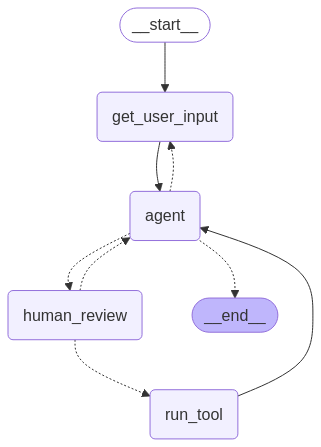

In [ ]:
memory = MemorySaver()

graph = builder.compile(checkpointer=memory)
# 중간 상태 저장을 위해 체크포인터가 필요합니다!
graph

In [ ]:
from rich import print as rprint
# Input
initial_input = {"messages": []}

# Thread
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    rprint(event)
    rprint("\n")

삼성 라이온즈의 2025년 중견수가 누구니?


{
    'get_user_input': {
        'messages': [
            HumanMessage(
                content='삼성 라이온즈의 2025년 중견수가 누구니?',
                additional_kwargs={},
                response_metadata={},
                id='fea5b8fc-9afc-41de-96a0-521b9bf6b757'
            )
        ]
    }
}

{
    'agent': {
        'messages': [
            AIMessage(
                content='',
                additional_kwargs={
                    'function_call': {
                        'name': 'search_blogs',
                        'arguments': '{"display": 5.0, "query": "\\uc0bc\\uc131 \\ub77c\\uc774\\uc628\\uc988 
2025\\ub144 \\uc911\\uacac\\uc218"}'
                    }
                },
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'safety_ratings': []
                },
                id='run-3e7e3da9-05b6-44d9-8694-462091ec99ed-0',
                tool_calls=[
                    {
                        'name': 'search_blogs',
                        'args': {'display': 5.0, 'query': '삼성 라이온즈 2025년 중견수'},
                        'id': '3ad99e7b-7445-4f2e-9669-a7c1014cee94',
                        'type': 'tool_call'
                    }
                ],
                usage_metadata={
                    'input_tokens': 150,
                    'output_tokens': 19,
                    'total_tokens': 169,
                    'input_token_details': {'cache_read': 0}
                }
            )
        ]
    }
}

{
    '__interrupt__': (
        Interrupt(
            value={
                'question': '이대로 진행할까요?',
                'tool_call': {
                    'name': 'search_blogs',
                    'args': {'display': 5.0, 'query': '삼성 라이온즈 2025년 중견수'},
                    'id': '3ad99e7b-7445-4f2e-9669-a7c1014cee94',
                    'type': 'tool_call'
                }
            },
            resumable=True,
            ns=['human_review:7e0d3b67-8dfc-a4f7-925a-61f0656db419']
        ),
    )
}

`__interrupt__`가 구성되면, 사용자 확인을 위해 중단된 상황입니다.

In [ ]:
print("graph 현재 상황")
print(graph.get_state(thread).next)

graph 현재 상황
('human_review',)


`human_review`에 기록된 값 중 하나를 입력하여 작업을 재개합니다.   
`Command`의 resume으로 값을 보낼 수 있습니다.

1. `{"action": "continue"}`
2. `{"action": "update", "data": {"query": "새로운 쿼리"}}`
3. `{"action": "feedback", "data": {"query": "전달할 피드백 내용"}}`

### Continue
run_tool으로 진행합니다.

In [ ]:
for event in graph.stream(

    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

Decision: continue 
 Content: None
{'human_review': None}


{'run_tool': {'messages': [ToolMessage(content='[{"title": "2025년 03월 16일 삼성 라이온즈 KIA 타이거즈 기아 kbo... ", "link": "https://blog.naver.com/mc_kwak/223797598618", "description": "기아 vs 삼성 프로야구 실시간 경기 정보를 확인하세요! KBO 야구예매 및 시청 2025년 03월 16일 삼성 라이온즈 KIA 타이거즈 KIA 타이거즈와 삼성 라이온즈의 2025 KBO 시범경기가 오늘 펼쳐집니다. 경기... ", "postdate": "20250316"}, {"title": "푸른 뱀의 해, 삼성 라이온즈 김지찬-황동재의 2025년", "link": "https://blog.naver.com/elxhrtmdnlcl126/223726893692", "description": "지키는 중견수가 되었다. 푸른 뱀의 해, 푸른 유니폼을 입은 김지찬이 더욱 날아오를 시간이다. 팀의 주전으로서, 리드오프로서 빛날 김지찬의 2025년을 기대한다. 제공 - 삼성 라이온즈 황동재 (2001.11.03)... ", "postdate": "20250115"}, {"title": "삼성 라이온즈, 2025년 주전 우익수 후보군과 외야 뎁스는?(KBO)", "link": "https://blog.naver.com/agentwannabe/223738489332", "description": "구자욱이, 중견수는 김지찬이 변함없이 맡을 것으로 보이는데, 오늘은 다음 시즌 삼성 라이온즈의... 박승규(OF) 2000.09.02 박승규 타격에 물음표가 있지만, 외야 수비 장인 박승규도 2025년 복귀를 앞두고... ", "postdate": "20250126"}, {"title": "삼성 라이온즈 신인 배찬승, 개막전 로스터 탑승 완료", "link": "h

### Update
Command로 전달되는 값을 받아 갱신합니다.   
검색 쿼리를 수정하기로 설정했으므로, 바뀐 쿼리를 전달하게 됩니다.

In [ ]:
thread = {"configurable": {"thread_id": "2"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

2025년 넷플릭스 한국 드라마 기대작 알려줘!
{'get_user_input': {'messages': [HumanMessage(content='2025년 넷플릭스 한국 드라마 기대작 알려줘!', additional_kwargs={}, response_metadata={}, id='604e9724-8c0a-4f23-a595-51ccee23d99f')]}}


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search_blogs', 'arguments': '{"display": 5.0, "query": "2025\\ub144 \\ub137\\ud50c\\ub9ad\\uc2a4 \\ud55c\\uad6d \\ub4dc\\ub77c\\ub9c8", "sort": "sim"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-69004663-a4f7-4f6f-abfe-7d3913e2ff70-0', tool_calls=[{'name': 'search_blogs', 'args': {'display': 5.0, 'query': '2025년 넷플릭스 한국 드라마', 'sort': 'sim'}, 'id': '37901440-3671-44ae-afd0-929b1a8d1dc5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 150, 'output_tokens': 20, 'total_tokens': 170, 'input_token_details': {'cache_read': 0}})]}}


{'__interrupt__': (Interrupt(value={'question': '이대로 진행할까요?', 'tool_

In [ ]:
for event in graph.stream(
    Command(resume={"action": "update", "data": {"query": "2025 넷플릭스 한국드라마 기대작"}}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

Decision: update 
 Content: {'query': '2025 넷플릭스 한국드라마 기대작'}
{'human_review': {'messages': [{'role': 'ai', 'content': '', 'tool_calls': [{'id': '37901440-3671-44ae-afd0-929b1a8d1dc5', 'name': 'search_blogs', 'args': {'query': '2025 넷플릭스 한국드라마 기대작'}}], 'id': 'run-69004663-a4f7-4f6f-abfe-7d3913e2ff70-0'}]}}


{'run_tool': {'messages': [ToolMessage(content='[{"title": "2025년 넷플릭스 한국 드라마 개인적인 기대작 3편", "link": "https://blog.naver.com/airumeraru/223721702475", "description": "오랜만에 내가 보고 싶은 작품 정리 차 작성해 보는 2025년 넷플릭스 한국 드라마 지극히 개인적인 취향을 반영한 기대작 정리 그리고 보니 오징어 게임 시즌 2는 홍보 엄청 한 거에 비해선 나는 화장실에서... ", "postdate": "20250110"}, {"title": "2025년 2~3월 한국 드라마 &amp; 예능 기대작 총정리! 넷플릭스... ", "link": "https://blog.naver.com/toxication7/223761389312", "description": "#한국드라마 #한국예능 #2025기대작 #넷플릭스드라마 #티빙 #디즈니플러스 #쿠팡플레이 #SBS #MBC #KBS #tvN #JTBC #신작드라마 #연애리얼리티 #사극 #판타지 #로맨틱코미디", "postdate": "20250215"}, {"title": "2025년 넷플릭스(Netflix) 한국 드라마 기대작 총정리!... ", "link": "https://blog.naver.com/simon220716/223781437012",

### feedback   
구현 방식에 따라, 자연어로 구성된 피드백을 전달하면 이를 반영하여 수정할 수도 있습니다.

In [ ]:
thread = {"configurable": {"thread_id": "3"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

오늘 친구들이랑 역삼역에 가기로 했는데, 역삼 근처 카페 추천해줘.
{'get_user_input': {'messages': [HumanMessage(content='오늘 친구들이랑 역삼역에 가기로 했는데, 역삼 근처 카페 추천해줘.', additional_kwargs={}, response_metadata={}, id='7a663bc9-15a8-49a3-8590-3411d1af5a4a')]}}


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search_blogs', 'arguments': '{"display": 5.0, "query": "\\uc5ed\\uc0bc\\uc5ed \\uadfc\\ucc98 \\uce74\\ud398", "sort": "sim"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-284e5df8-3136-4a36-ac7b-296cb42b0331-0', tool_calls=[{'name': 'search_blogs', 'args': {'display': 5.0, 'query': '역삼역 근처 카페', 'sort': 'sim'}, 'id': 'b60617f9-1478-426e-82b5-88caf3b04537', 'type': 'tool_call'}], usage_metadata={'input_tokens': 157, 'output_tokens': 14, 'total_tokens': 171, 'input_token_details': {'cache_read': 0}})]}}


{'__interrupt__': (Interrupt(value={'question': '이대로 진행할까요?', 'tool_call': {'nam

In [ ]:
for event in graph.stream(
    Command(
        resume={
            "action": "feedback",
            "data": "아 우리 보드게임카페 가기로 했어.",
        }
    ),
    thread,
    stream_mode="values",
):
    print(event)
    print("\n")

{'messages': [HumanMessage(content='오늘 친구들이랑 역삼역에 가기로 했는데, 역삼 근처 카페 추천해줘.', additional_kwargs={}, response_metadata={}, id='7a663bc9-15a8-49a3-8590-3411d1af5a4a'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'search_blogs', 'arguments': '{"display": 5.0, "query": "\\uc5ed\\uc0bc\\uc5ed \\uadfc\\ucc98 \\uce74\\ud398", "sort": "sim"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-284e5df8-3136-4a36-ac7b-296cb42b0331-0', tool_calls=[{'name': 'search_blogs', 'args': {'display': 5.0, 'query': '역삼역 근처 카페', 'sort': 'sim'}, 'id': 'b60617f9-1478-426e-82b5-88caf3b04537', 'type': 'tool_call'}], usage_metadata={'input_tokens': 157, 'output_tokens': 14, 'total_tokens': 171, 'input_token_details': {'cache_read': 0}})]}


Decision: feedback 
 Content: 아 우리 보드게임카페 가기로 했어.
{'messages': [HumanMessage(content='오늘 친구들이랑 역삼역에 가기로 했는데, 역삼 근처 카페 추천해줘.', additional_kwargs={}, response_metadata=

In [ ]:
# 다시 Agent로 전달되었으므로 다시 Interrupt 발생
print("다음 상태")
print(graph.get_state(thread).next)

다음 상태
('human_review',)


In [ ]:
for event in graph.stream(
    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

Decision: continue 
 Content: None
{'human_review': None}


{'run_tool': {'messages': [ToolMessage(content='[{"title": "[강남/역삼] 보드게임카페 레드버튼 시네마강남", "link": "https://blog.naver.com/h0neylight/223593471719", "description": "보드게임카페 레드버튼 시네마강남 주소 : 서울 강남구 강남대로 422 4층, 5층 번호 : 02-556-3799 영업시간 : 매일 13:00 ~ 01:00 이 포스팅은 일절 협찬 받지 않은 내돈내산이며, 평가 또한 주관적임을... ", "postdate": "20240923"}, {"title": "강남역놀거리 역삼역보드게임카페 다이스타운", "link": "https://blog.naver.com/keyofus/223785125217", "description": "강남보드게임카페 다이스타운과 사랑에 빠진 순간 먼저 자리안내를 해주시는데, 자리에서 메뉴판을 보고 원하는 게임들과 음료를 골라요! 강남역보드게임카페 다이스타운의 특별한점은 구매도 가능하다는... ", "postdate": "20250305"}, {"title": "[강남역/신논현역/역삼역]넓고 쾌적한 보드게임 카페... ", "link": "https://blog.naver.com/yeshyun16/223096748792", "description": "게임은 한개씩! 중도입장,퇴실 시 카운터에 문의~ 기본적인 주의사항 아시죠? 규모가 엄청커서 방도... 테이블그라운드강남점 #역삼역보드게임카페 #신논현보드게임카페 #신논현실내데이트 #역삼실내데이트... ", "postdate": "20230508"}, {"title": "[역삼 만화카페, 보드게임 카페/ 만화책, 보드게임 놀거리]... ", "link": "https://blog.naver.com/sophia0p0/223483498296", "descript

Langsmith (https://smith.langchain.com )에서 실행 결과를 확인할 수 있습니다.